## Diffusion Gradient Representation (Cellpose)

In [1]:
import numpy as np
from connectomics.config import get_cfg_defaults
from connectomics.data.dataset.build import _get_input
from connectomics.data.utils import seg2diffgrads, seg_widen_border, dx_to_circ

In [2]:
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

def show(image, cmap='viridis', title='Test Title', interpolation=None):  
    num_imgs = image.shape[-3]
    fig = plt.figure(figsize=(20., 3.),)
    fig.suptitle(title, fontsize=15)
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                     nrows_ncols=(1, num_imgs),  # creates 2x2 grid of axes
                     axes_pad=0.1,  # pad between axes in inch.
                     )
    image_list = np.split(image, num_imgs, -3)
    for ax, im in zip(grid, [np.squeeze(x) for x in image_list]):
        if im.ndim==3 and im.shape[0] in [2,3,4]: # multi-channel
            im = im.transpose(1,2,0)
        # Iterating over the grid returns the Axes.
        ax.imshow(im, cmap=cmap, interpolation=interpolation)
        ax.axis('off')

    plt.show()

In [4]:
# Load configs and dataset
# for 2D dataset:
# cfg_filename = '../configs/Cellpose/Cellpose-Base.yaml'

# for 3D dataset:
cfg_filename = '../configs/SNEMI/SNEMI-Base.yaml' # should be in the configs/ directory
cfg = get_cfg_defaults()
cfg.merge_from_file(cfg_filename)
cfg.DATASET.PAD_SIZE = [0,0,0]
cfg.DATASET.INPUT_PATH = "../datasets/SNEMI3D/"

images, labels, _ = _get_input(cfg, 'train')
images = np.array(images)
labels = np.array(labels)
(images.shape,labels.shape)

None 1 ['train_image.h5']
volume shape (original): (100, 1024, 1024)
volume shape (after scaling and padding): (100, 1024, 1024)
label shape (after scaling and padding): (100, 1024, 1024)


((1, 100, 1024, 1024), (1, 100, 1024, 1024))

In [5]:
# crop a subvolume for visualization
image_vol = images[0, 50:58, 400:657, 400:657]
label_vol = labels[0, 50:58, 400:657, 400:657]
label_vol = seg_widen_border(label_vol)

cellpose = seg2diffgrads(label_vol)
foreground = (label_vol!=0).astype(np.float32)[np.newaxis,:]
cellpose = np.concatenate([cellpose, foreground], 0)
for i in range(3):
    print("value range: (%.3f, %.3f)" % (cellpose[i].min(), cellpose[i].max()))

value range: (-1.000, 1.000)
value range: (-1.000, 1.000)
value range: (0.000, 1.000)


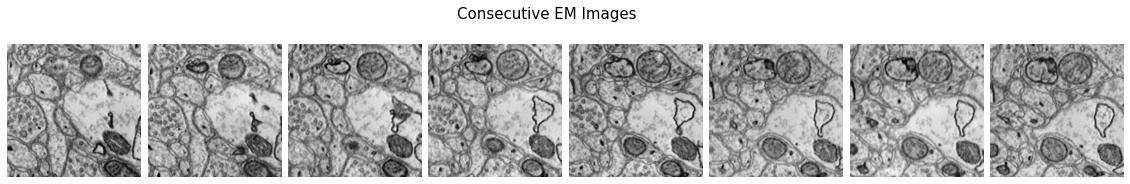

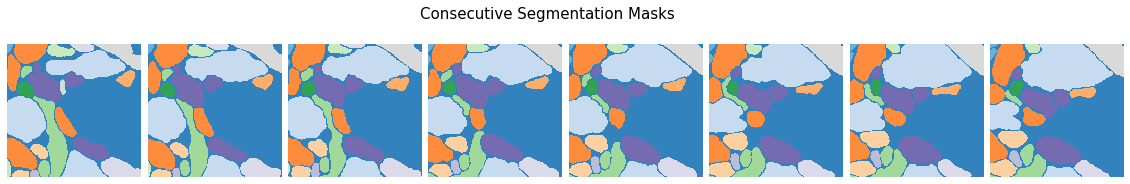

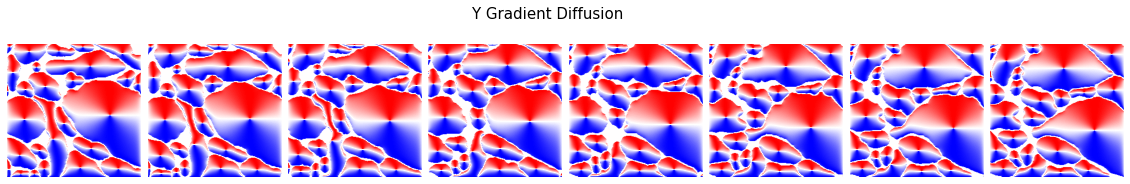

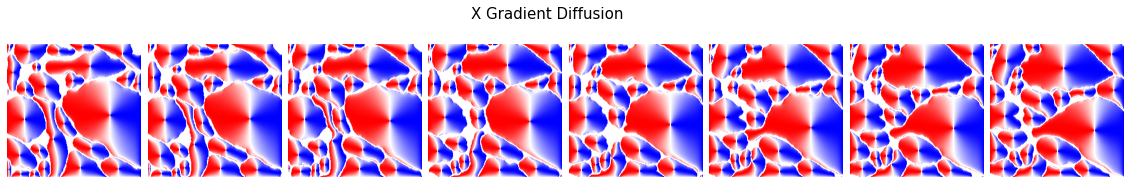

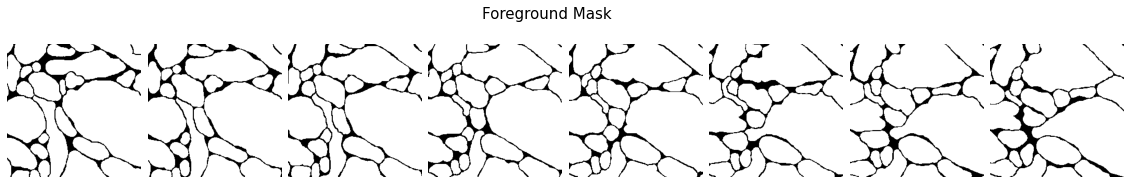

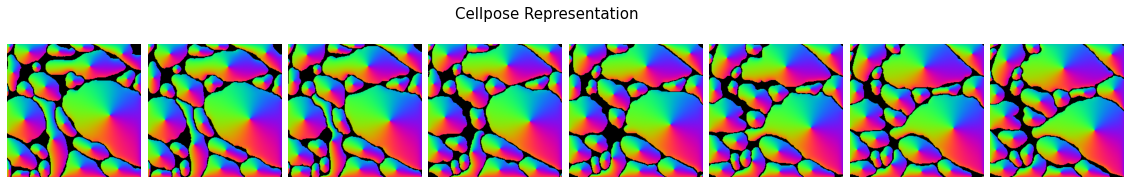

In [6]:
show(image_vol, title = 'Consecutive EM Images', cmap = "gray")
show(label_vol, title = 'Consecutive Segmentation Masks', cmap = "tab20c", interpolation="none")
show(cellpose[0], title = 'Y Gradient Diffusion', cmap = "bwr")
show(cellpose[1], title = 'X Gradient Diffusion', cmap = "bwr")
show(cellpose[2], title = 'Foreground Mask', cmap = "gray")

cellpose_vis = np.transpose(cellpose.copy(),(1,0,2,3))
cellpose_vis = dx_to_circ(cellpose_vis[:,:2])
show(cellpose_vis, title = 'Cellpose Representation')